In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
%run function.ipynb

np.set_printoptions(suppress=False)

In [2]:
df = pd.read_csv('clean4.csv')
df_copy = df.copy()
print(df_copy.shape)
df_copy.head(3)

(899153, 45)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,...,Population,PopDensity,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome,USDPerJobCreated,DisbursePerEmployee,GrSBA_AppvDiff%,State_division
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,1997-02-28,84.0,4.0,...,31457.0,1939.0,14267.0,12895.0,115600.0,48618.0,60000.0,12000.000000,20.0,Mid-West
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1997-02-28,60.0,2.0,...,30671.0,457.0,11847.0,10938.0,120200.0,47863.0,40000.0,13333.333333,20.0,Mid-West
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,1997-02-28,180.0,7.0,...,41011.0,495.0,19124.0,17562.0,207900.0,45415.0,287000.0,35875.000000,25.0,Mid-West


In [3]:
# no employee but retain some jobs
df_emp_weird = df_copy[((df_copy['NoEmp'] == 0) & (df_copy['RetainedJob'] != 0)) | ((df_copy['NoEmp'] + df_copy['CreateJob']) < df_copy['RetainedJob'])]
df_copy.drop(list(df_emp_weird.index), axis=0, inplace=True)
print(df_emp_weird.shape)

# weird data create so many job(8800)
df_job_weird = df_copy[(df_copy['CreateJob'] == 8800)| (df_copy['RetainedJob'] == 8800) & (df_copy['NoEmp'] < 500)].sort_values(by=['CreateJob', 'DisbursementDate_year'], ascending=False)
# delete weird data
df_copy = df_copy.drop(list(df_job_weird.index), axis=0)
print(df_job_weird.shape)

(4056, 45)
(646, 45)


In [4]:
obj_features = ['State', 'BankState', 'NewExist', 'IsFranchised', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Industry',
            'ApprovalDate_year', 'ApprovalDate_month', 'DisbursementDate_year', 'DisbursementDate_month', 'State_division']
num_features = ['Default', 'ChgOffPrinGr', 'Term', 'DisbursementGross', 'GrSBA_AppvDiff%', 'DisbursePerEmployee',
                'USDPerJobCreated','NoEmp', 'CreateJob', 'RetainedJob', 'Population', 'PopDensity', 'GrAppv', 'SBA_Appv',
                'HousingUnits', 'OccupiedHousingUnits', 'MedianHomeValue', 'MedianHouseholdIncome']
time_cols = ['ApprovalDate_year', 'ApprovalDate_month', 'DisbursementDate_year', 'DisbursementDate_month']

In [5]:
df_groupby_mean = dict()
df_groupby_size = dict()

for col in obj_features:
    df_groupby_mean[col] = df_copy.groupby(by=col).mean()[num_features]
    df_groupby_size[col] = pd.DataFrame(df_copy.groupby(by=col).size())
    df_groupby_size[col].rename(columns={0: 'size'}, inplace=True)

# LowDoc延伸分析

In [6]:
data = df_copy.groupby(by=['DisbursementDate_year', 'LowDoc']).mean()
data_long = data.melt(ignore_index=False).reset_index()
data_def = data_long[data_long['variable'] == 'Default']

data_def = data_def[data_def['DisbursementDate_year'] >= 1972]
data_def[['DisbursementDate_year', 'LowDoc']] = data_def[['DisbursementDate_year', 'LowDoc']].applymap(lambda x: int(x))
data_def.head(3)

,DisbursementDate_year,LowDoc,variable,value
1037,1972,0,Default,0.971429
1038,1973,0,Default,0.977778
1039,1974,0,Default,1.000000


In [7]:
year_list = list(df_groupby_mean['ApprovalDate_year'][~(df_copy.groupby(by='ApprovalDate_year').size().values < 30)].index)

In [8]:
data = pd.DataFrame(df_copy.groupby(by=['DisbursementDate_year', 'LowDoc']).size()).reset_index()
data.rename(columns={0: 'count'}, inplace=True)
data = data[data['DisbursementDate_year'] >= 1972]
data[['DisbursementDate_year', 'LowDoc']] = data[['DisbursementDate_year', 'LowDoc']].applymap(lambda x: int(x))
data.head(3)

,DisbursementDate_year,LowDoc,count
5,1972,0,35
6,1973,0,45
7,1974,0,35


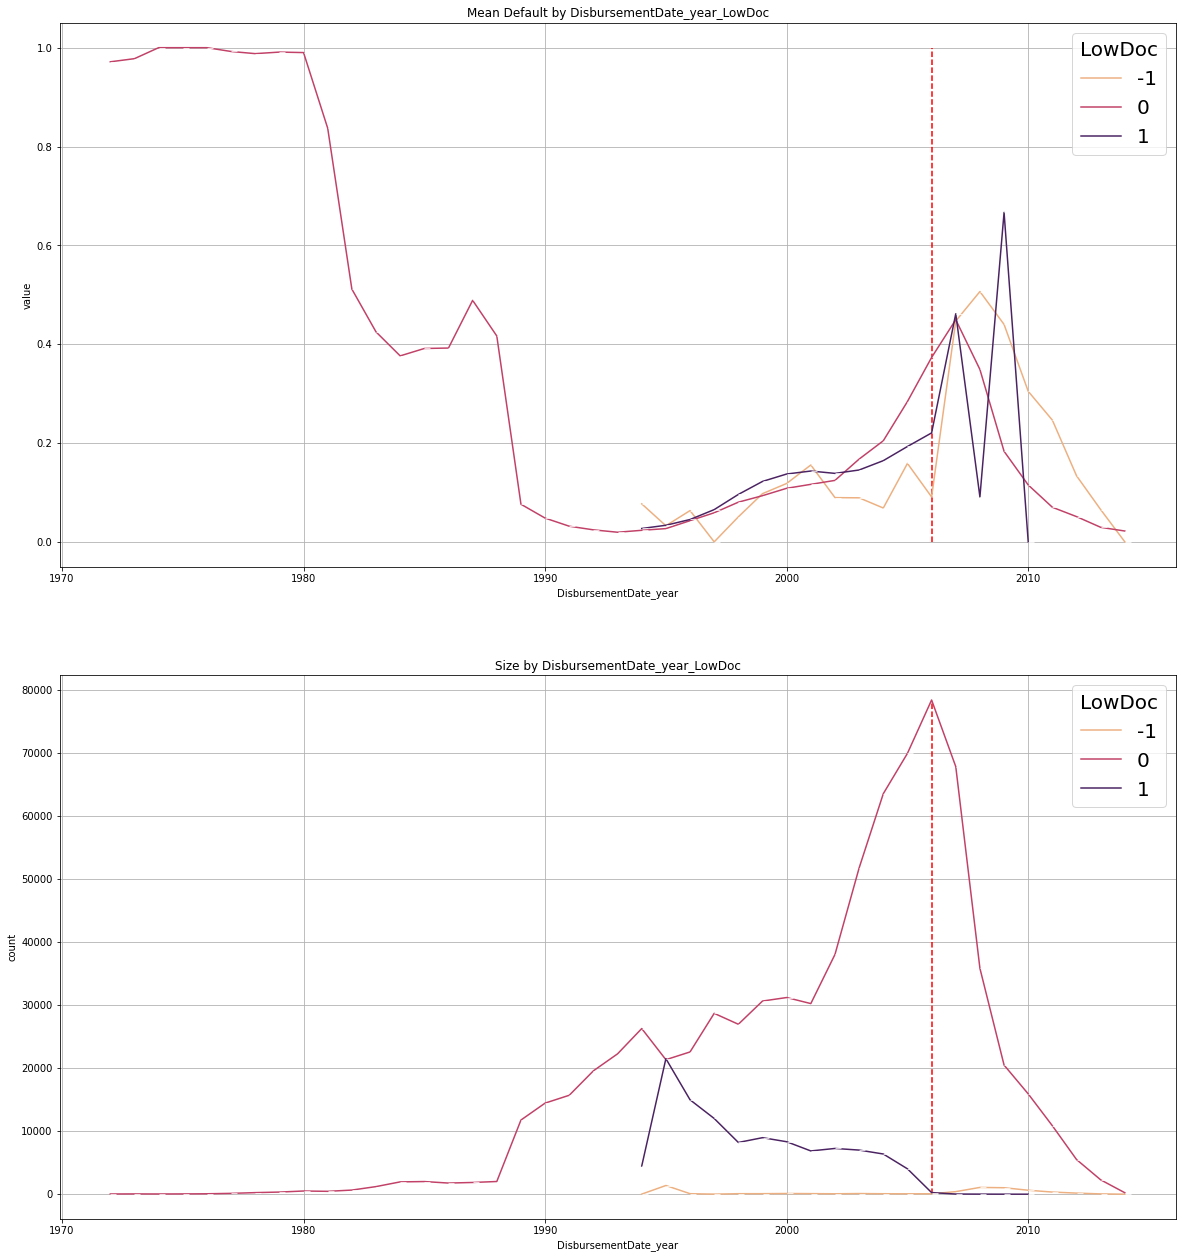

In [9]:
plt.figure(figsize=(20,22))

num = 'Default'

plt.subplot(2, 1, 1)
plt.title('Mean {} by DisbursementDate_year_LowDoc'.format(num))
plt.grid(True)
plt.vlines(x=[2006.0], ymin=data_def['value'].min(), ymax=data_def['value'].max(), color='r', linestyles='dashed')
sns.lineplot(data=data_def, x=data_def['DisbursementDate_year'], y=data_def['value'], marker=True, hue='LowDoc',
             palette="flare")
plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)

plt.subplot(2, 1, 2)
plt.title('Size by DisbursementDate_year_LowDoc'.format(num))
plt.grid(True)
plt.vlines(x=[2006.0], ymin=data['count'].min(), ymax=data['count'].max(), color='r', linestyles='dashed')
sns.lineplot(data=data, x=data['DisbursementDate_year'], y=data['count'], marker=True, hue='LowDoc',
             palette="flare")
plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)

plt.show()

In [10]:
# plt.figure(figsize=(20, 10))

# num = 'Default'

# plt.title('Mean {} by DisbursementDate_year_LowDoc'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data_def['value'].min(), ymax=data_def['value'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data_def, x=data_def['DisbursementDate_year'], y=data_def['value'], marker=True, hue='LowDoc',
#              palette="flare")
# plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)
# plt.savefig('Mean {} by DisbursementDate_year_LowDoc.jpeg'.format(num))
# plt.show()

In [11]:
# plt.figure(figsize=(20, 10))

# plt.title('Size by DisbursementDate_year_LowDoc'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data['count'].min(), ymax=data['count'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data, x=data['DisbursementDate_year'], y=data['count'], marker=True, hue='LowDoc',
#              palette="flare")
# plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)
# plt.savefig('Size by DisbursementDate_year_LowDoc.jpeg')
# plt.show()

In [12]:
# steep decrease of LowDoc Loan between 05' and 06'
data[(data['DisbursementDate_year'] >= 2003) & (data['LowDoc'] == 1)]

,DisbursementDate_year,LowDoc,count
56,2003,1,7000
59,2004,1,6378
62,2005,1,4026
65,2006,1,254
68,2007,1,26
71,2008,1,11
74,2009,1,3
77,2010,1,1


# NoEmp為0的公司

comparison between NoEmp == 0 and the other

In [13]:
df_copy[df_copy['NoEmp'] == 0][num_features].describe()

,Default,ChgOffPrinGr,Term,DisbursementGross,GrSBA_AppvDiff%,DisbursePerEmployee,USDPerJobCreated,NoEmp,CreateJob,RetainedJob,Population,PopDensity,GrAppv,SBA_Appv,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome
count,5127.000000,1.210000e+03,5127.000000,5.127000e+03,5127.000000,5.127000e+03,5.127000e+03,5127.0,5127.000000,5127.0,5127.000000,5127.000000,5.127000e+03,5.127000e+03,5127.000000,5127.000000,5.127000e+03,5127.000000
mean,0.236005,7.888488e+04,74.023796,1.397205e+05,41.571190,1.225292e+05,6.333753e+04,0.0,2.780964,0.0,27864.050907,2955.821143,1.248359e+05,8.712629e+04,11816.108445,10805.048957,2.089646e+05,59374.005851
std,0.424667,1.306175e+05,46.870571,2.914615e+05,14.423829,2.619195e+05,1.781609e+05,0.0,15.452550,0.0,16512.588340,6290.782261,2.850022e+05,2.315545e+05,6672.651139,6172.304101,1.343653e+05,21422.145182
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000000,0.000000,1.212217e+03,6.061084e+02,0.000000,0.000000,2.010000e+04,10182.000000
25%,0.000000,1.838015e+04,60.000000,2.854407e+04,25.000000,2.500000e+04,1.500000e+04,0.0,0.000000,0.0,15887.000000,356.000000,2.604899e+04,1.359656e+04,7166.500000,6322.500000,1.270000e+05,44497.000000
50%,0.000000,2.708199e+04,60.000000,5.452717e+04,50.000000,4.850000e+04,2.530000e+04,0.0,0.000000,0.0,26540.000000,1369.000000,3.070692e+04,1.818325e+04,11433.000000,10477.000000,1.703000e+05,55297.000000
75%,0.000000,7.987403e+04,84.000000,1.406171e+05,50.000000,1.218980e+05,5.250000e+04,0.0,2.000000,0.0,38096.500000,3221.000000,1.174334e+05,7.007173e+04,16108.000000,14697.000000,2.431000e+05,70507.000000
max,1.000000,1.498308e+06,312.000000,5.517364e+06,80.000000,5.000000e+06,5.000000e+06,0.0,1000.000000,0.0,109931.000000,112711.000000,5.517364e+06,4.965628e+06,41483.000000,37865.000000,1.000001e+06,188452.000000


In [14]:
df_copy[(df_copy['NoEmp'] != 0)][num_features].describe()

,Default,ChgOffPrinGr,Term,DisbursementGross,GrSBA_AppvDiff%,DisbursePerEmployee,USDPerJobCreated,NoEmp,CreateJob,RetainedJob,Population,PopDensity,GrAppv,SBA_Appv,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome
count,889324.000000,1.603480e+05,889324.000000,8.893240e+05,889324.000000,8.893240e+05,8.893240e+05,889324.000000,889324.000000,889324.000000,889324.000000,889324.000000,8.893240e+05,8.893240e+05,889324.000000,889324.000000,8.893240e+05,889324.000000
mean,0.181895,8.841289e+04,110.977756,2.869559e+05,28.977832,3.140372e+04,1.450032e+05,11.503379,2.074576,4.378839,28524.951924,4011.314683,2.771660e+05,2.164364e+05,11870.695005,10804.037958,2.519378e+05,59015.580418
std,0.385759,1.604220e+05,78.957192,3.958790e+05,17.353232,5.775110e+04,2.380796e+05,74.501639,16.234735,14.422787,18008.960320,9086.908658,3.937003e+05,3.149520e+05,6940.960150,6414.107385,1.735734e+05,23042.581903
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,2.424433e+02,1.212217e+02,0.000000,0.000000,9.999000e+03,2499.000000
25%,0.000000,1.645031e+04,60.000000,5.729020e+04,15.000000,7.142857e+03,2.500000e+04,2.000000,0.000000,0.000000,15227.000000,377.000000,4.606392e+04,2.796738e+04,6775.000000,6046.000000,1.355000e+05,42938.000000
50%,0.000000,3.723280e+04,84.000000,1.374771e+05,25.000000,1.500000e+04,6.000000e+04,4.000000,0.000000,1.000000,27107.000000,1787.000000,1.253344e+05,8.949562e+04,11512.000000,10533.000000,1.963000e+05,54102.000000
75%,0.000000,8.682039e+04,120.000000,3.433845e+05,50.000000,3.260870e+04,1.500000e+05,10.000000,1.000000,4.000000,38803.000000,4097.000000,3.304546e+05,2.614125e+05,16187.000000,14821.000000,3.163000e+05,71192.000000
max,1.000000,4.622970e+06,569.000000,1.311624e+07,97.186004,2.500000e+06,1.144632e+07,9999.000000,5621.000000,3900.000000,113916.000000,172372.000000,6.038203e+06,6.038203e+06,47617.000000,44432.000000,1.000001e+06,250001.000000


In [15]:
df_emp0 = df_copy[(df_copy['NoEmp'] == 0)]

data contains 4841 rows and was divided into 13 groups.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

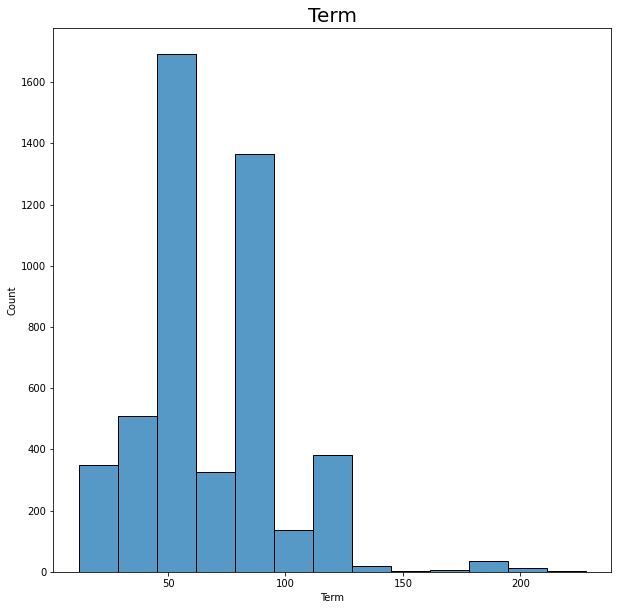

data contains 4869 rows and was divided into 13 groups.


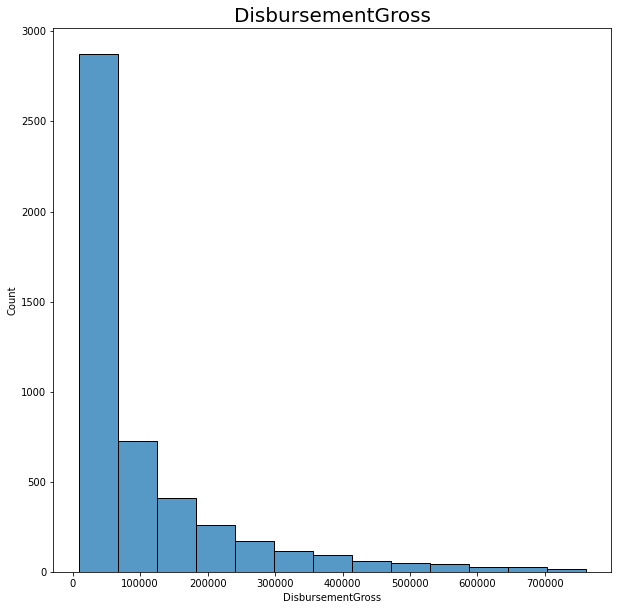

data contains 1107 rows and was divided into 11 groups.


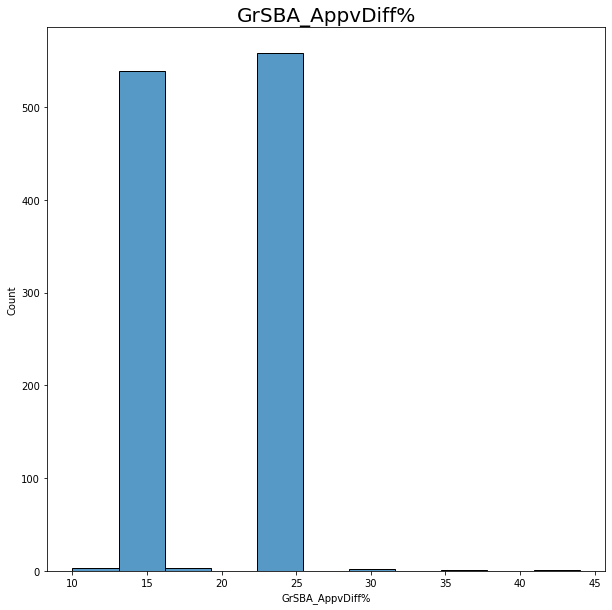

data contains 4864 rows and was divided into 13 groups.


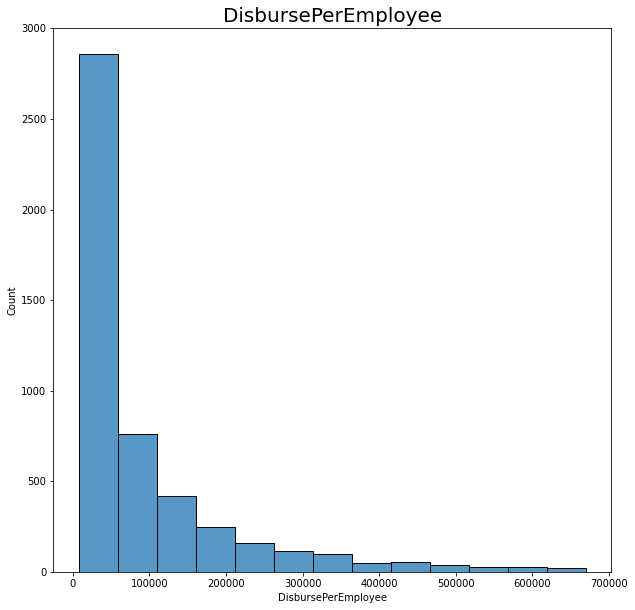

data contains 4867 rows and was divided into 13 groups.


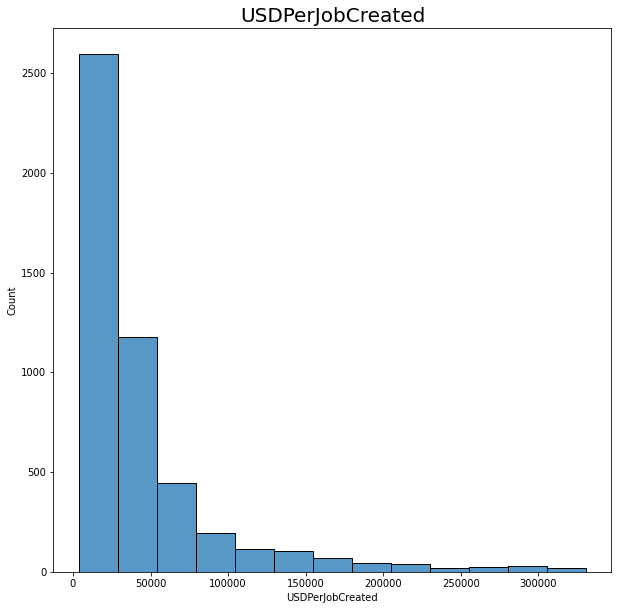

data contains 1774 rows and was divided into 11 groups.


<Figure size 720x720 with 0 Axes>

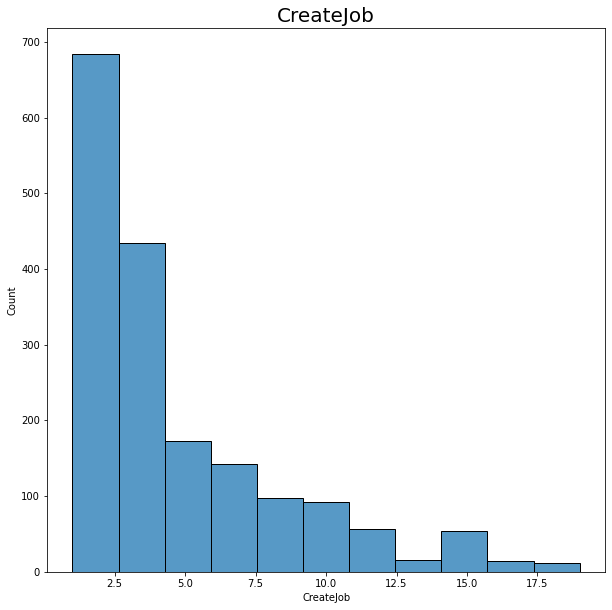

data contains 4869 rows and was divided into 13 groups.


<Figure size 720x720 with 0 Axes>

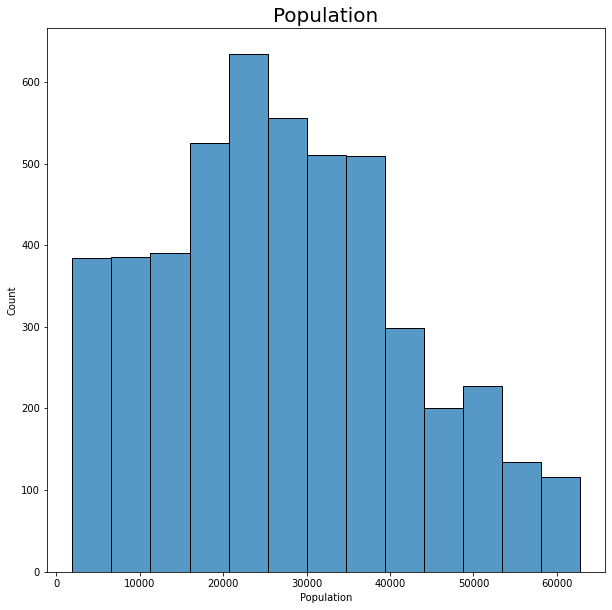

data contains 4864 rows and was divided into 13 groups.


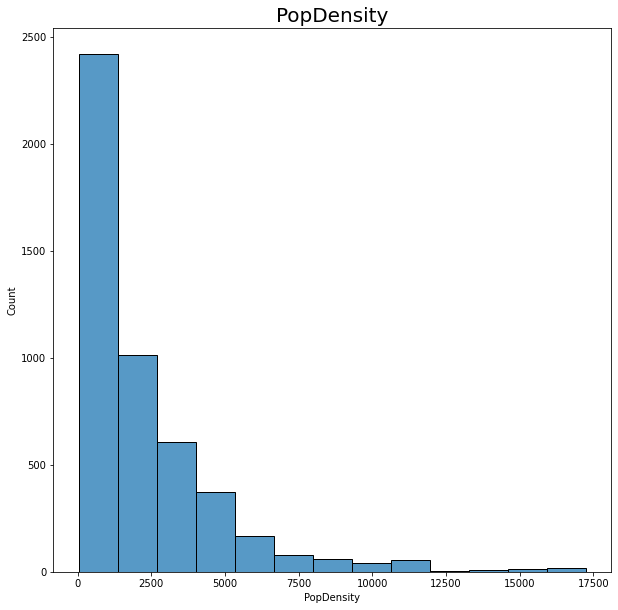

data contains 4869 rows and was divided into 13 groups.


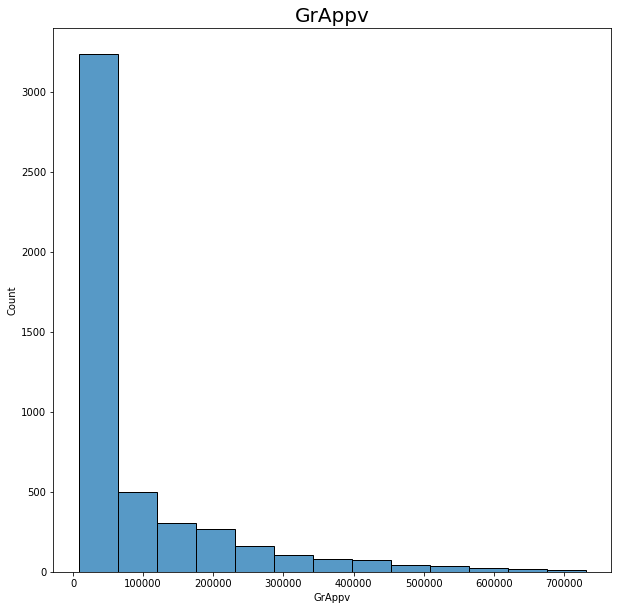

data contains 4869 rows and was divided into 13 groups.


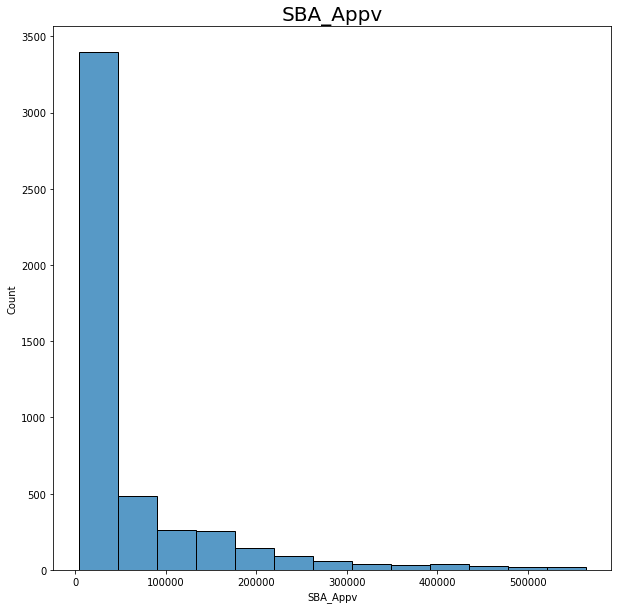

data contains 4869 rows and was divided into 13 groups.


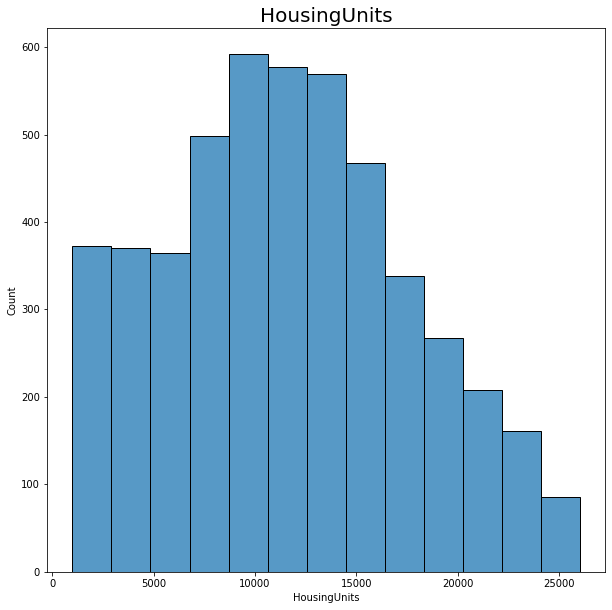

data contains 4868 rows and was divided into 13 groups.


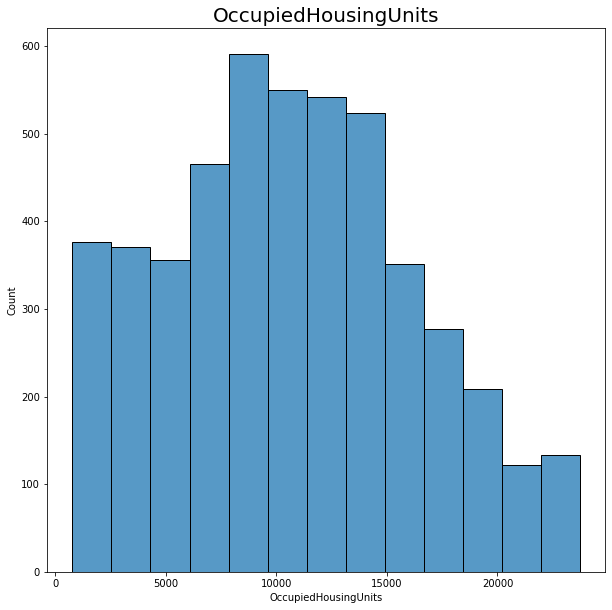

data contains 4869 rows and was divided into 13 groups.


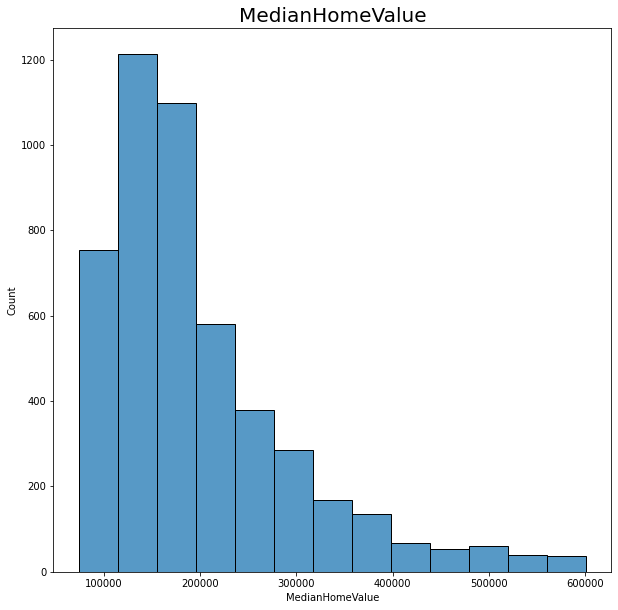

data contains 4851 rows and was divided into 13 groups.


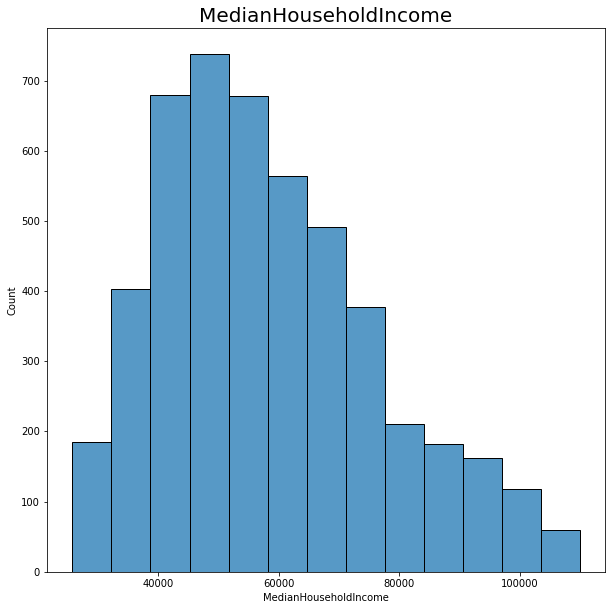

In [16]:
num_visualization(df_emp0, num_features)

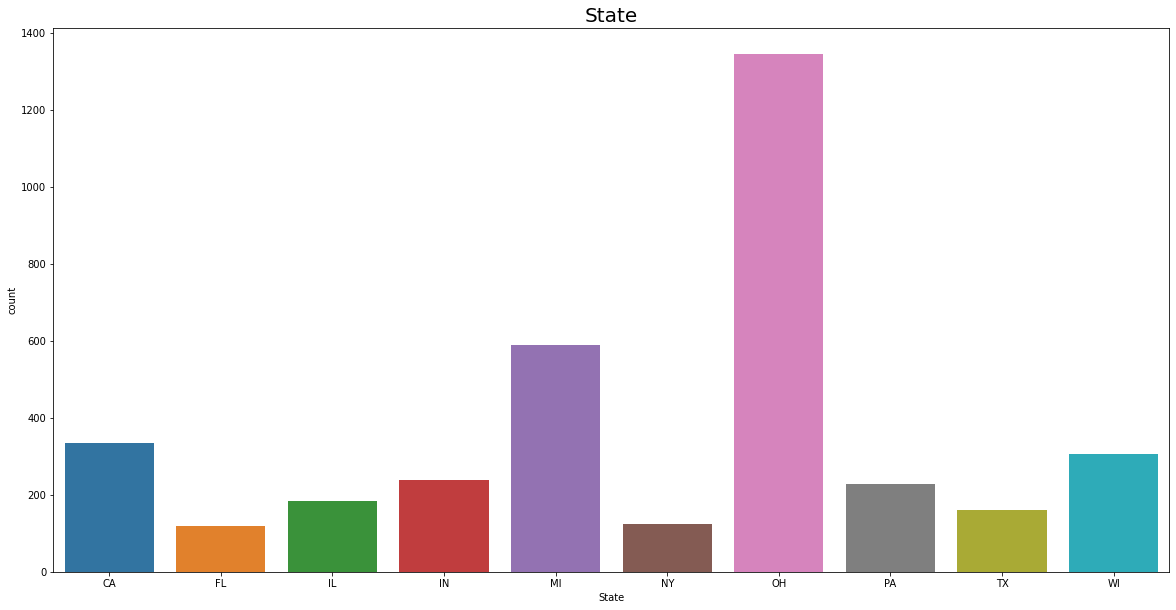

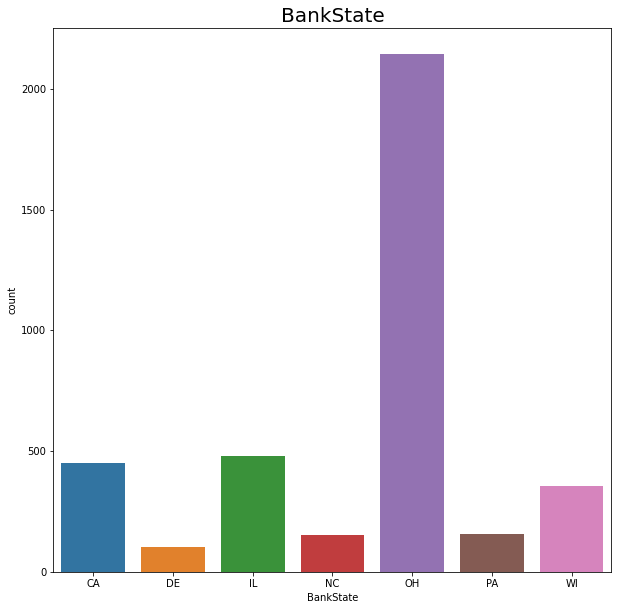

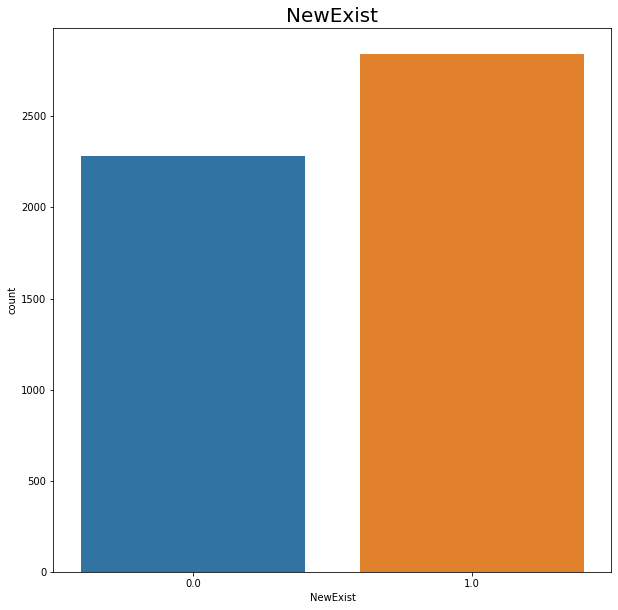

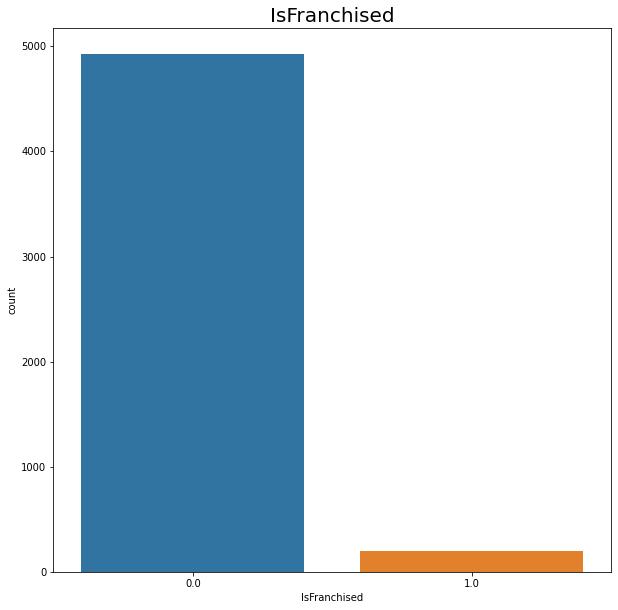

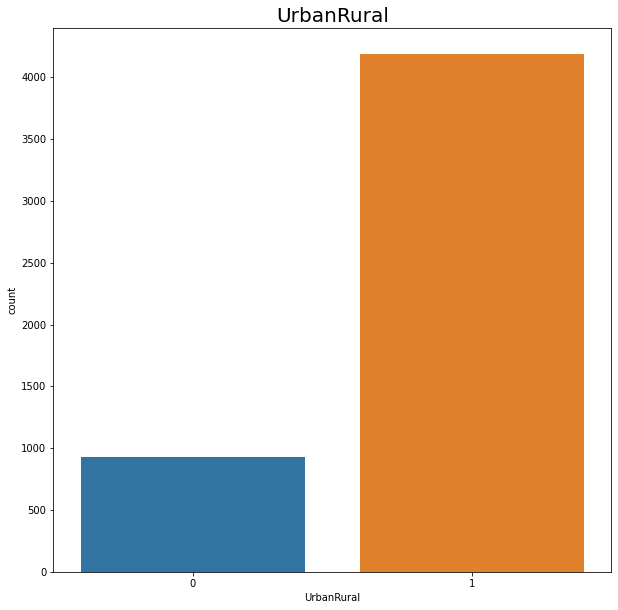

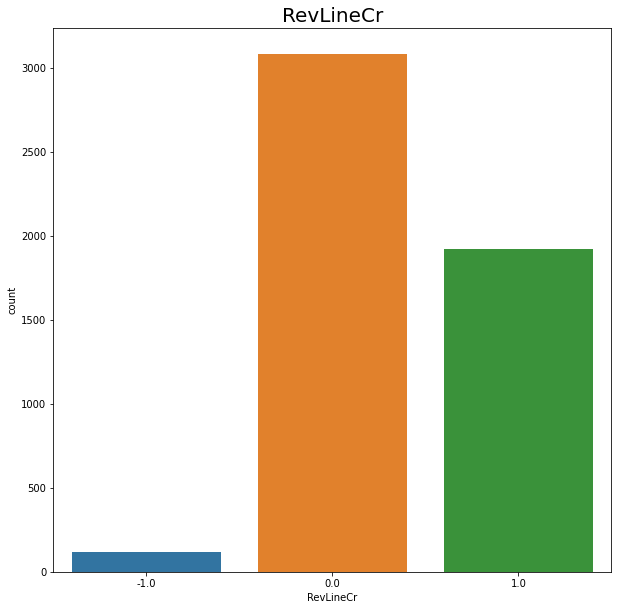

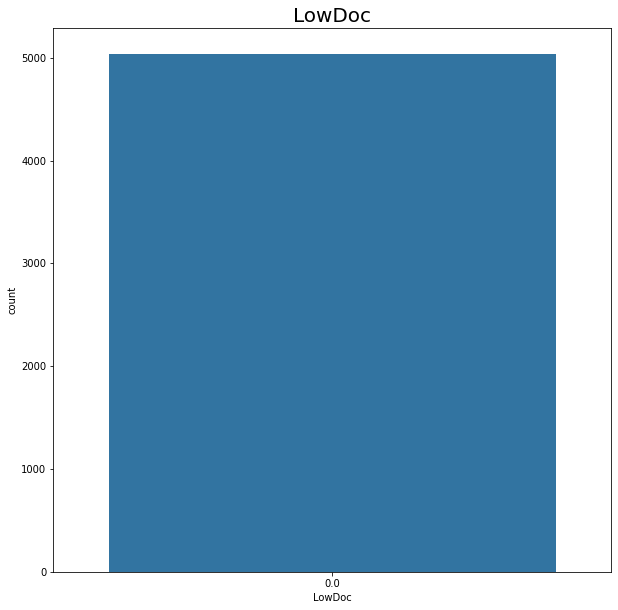

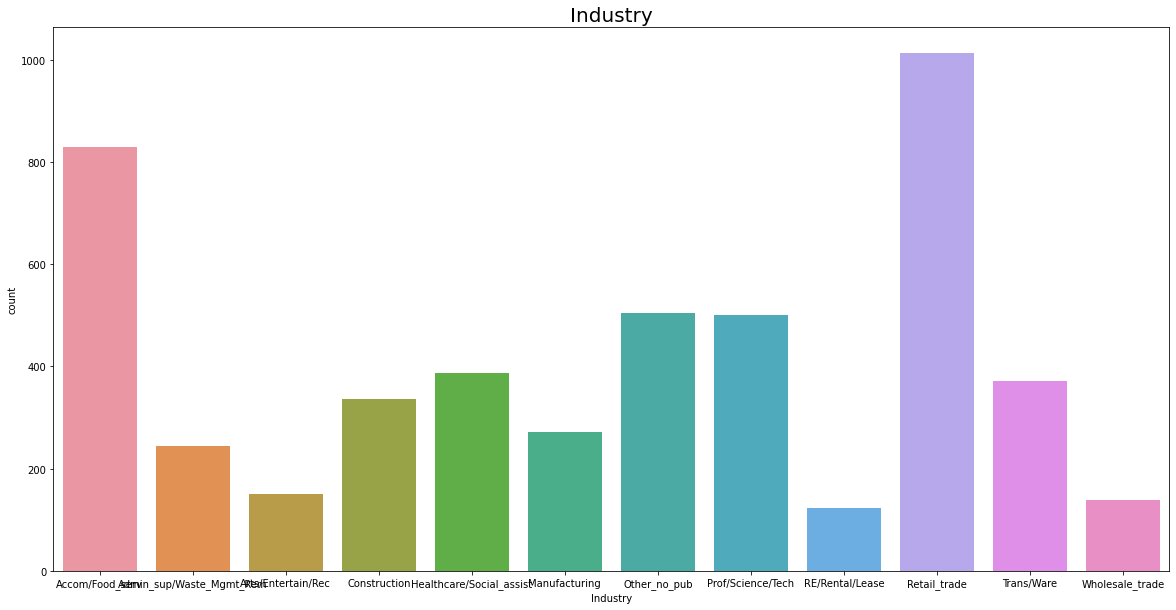

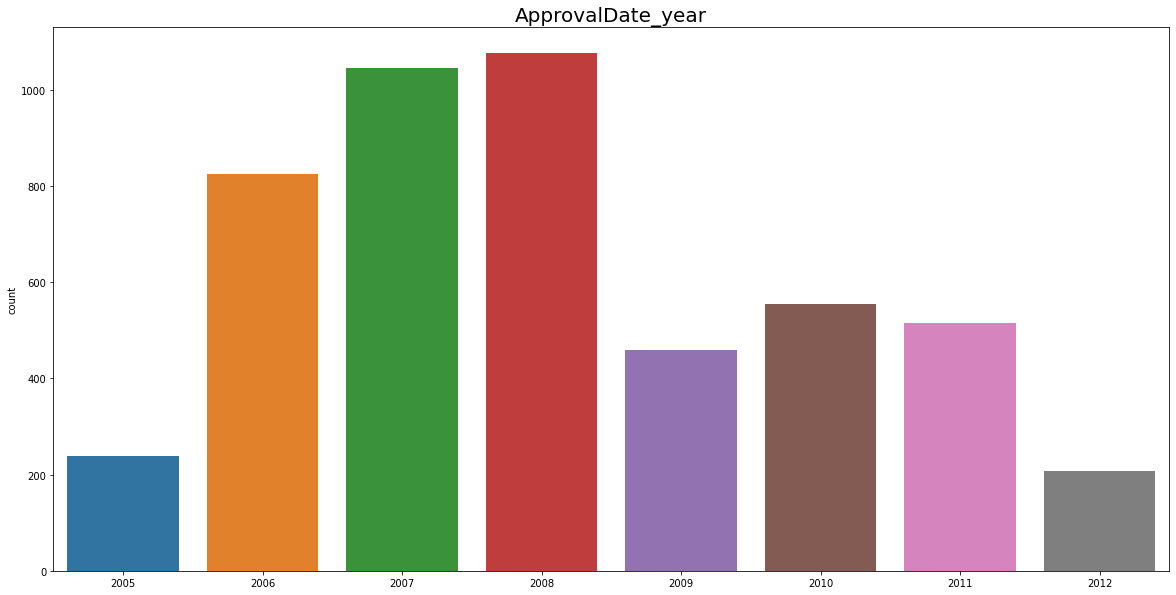

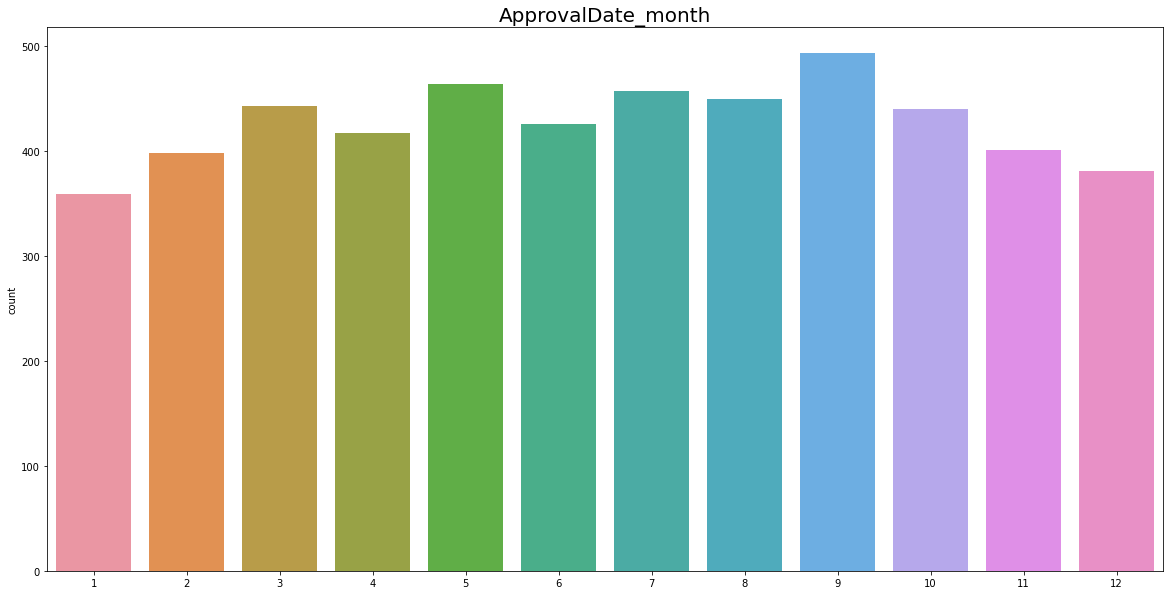

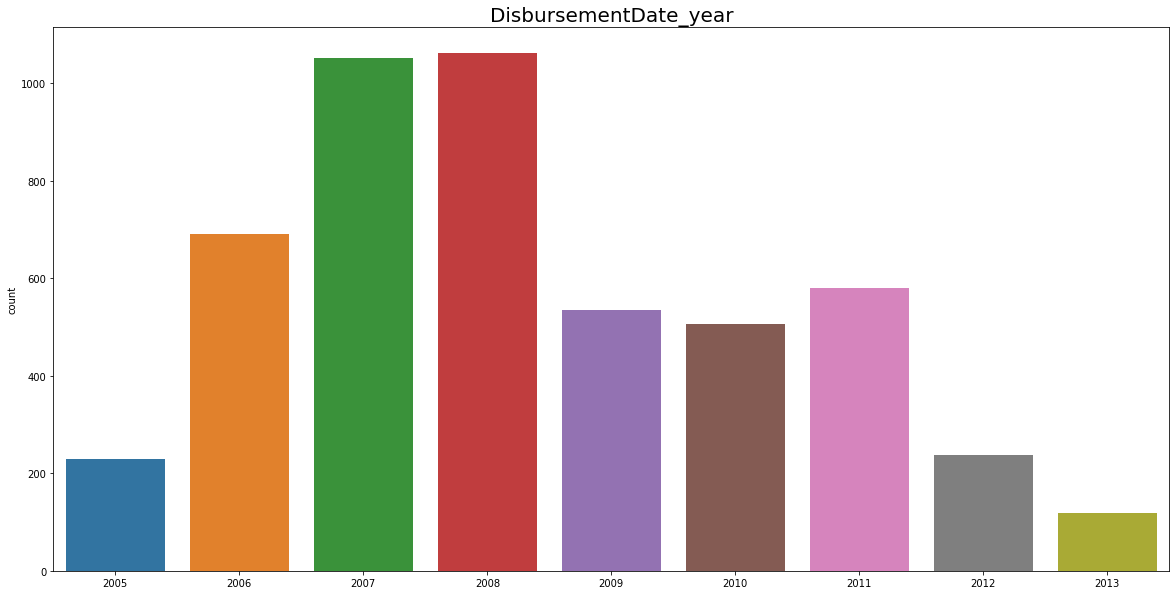

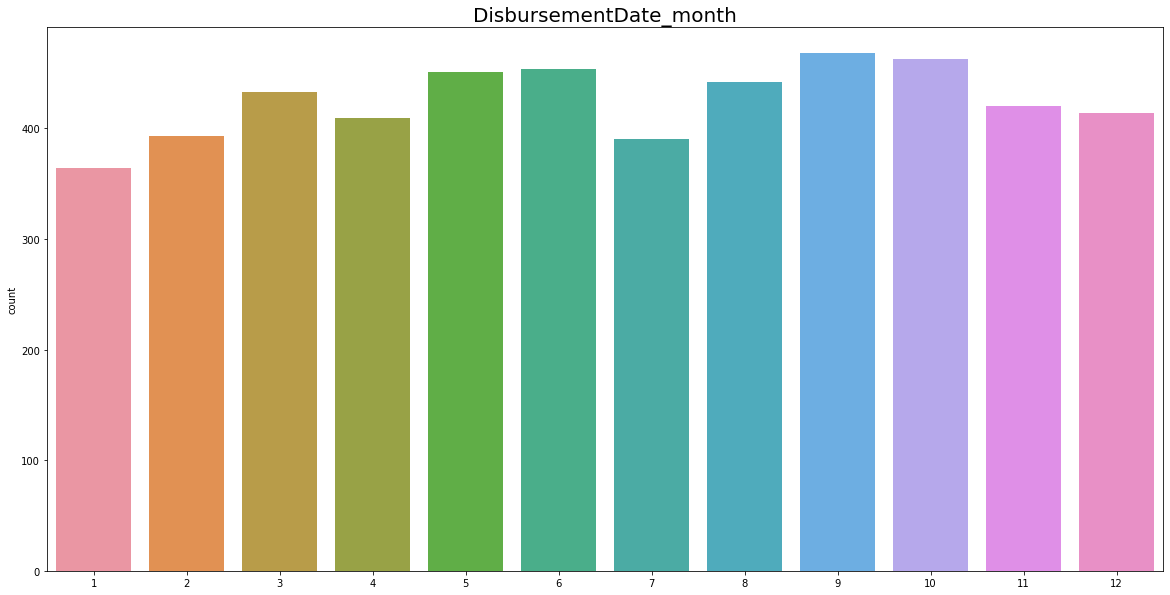

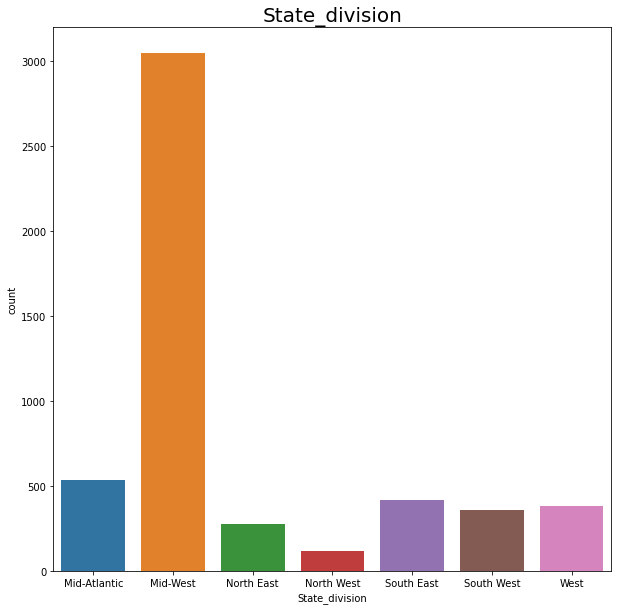

In [17]:
obj_visualization(df_emp0, obj_features)

# CreateJob相關問題

In [18]:
display(df_copy[(df_copy['DisbursementDate_year'] == 1987)][['CreateJob', 'DisbursementDate_year']].describe())
display(df_copy[(df_copy['DisbursementDate_year'] == 2006)][['CreateJob', 'DisbursementDate_year']].describe())

,CreateJob,DisbursementDate_year
count,1860.000000,1860.0
mean,8.118280,1987.0
std,120.933268,0.0
min,0.000000,1987.0
25%,0.000000,1987.0
50%,0.000000,1987.0
75%,6.000000,1987.0
max,5199.000000,1987.0


,CreateJob,DisbursementDate_year
count,78746.000000,78746.0
mean,2.206842,2006.0
std,12.358535,0.0
min,0.000000,2006.0
25%,0.000000,2006.0
50%,0.000000,2006.0
75%,2.000000,2006.0
max,2020.000000,2006.0


In [19]:
# weird data create so many job(>=1000)
df_job_weird = df_copy[(df_copy['CreateJob'] >= 500)| (df_copy['RetainedJob'] >= 500) & (df_copy['NoEmp'] < 500)].sort_values(by=['CreateJob', 'DisbursementDate_year'], ascending=False)
df_job_weird[['Name', 'State', 'CreateJob', 'RetainedJob', 'NoEmp', 'DisbursementDate_year', 'Term', 'Industry', 'IsFranchised', 'Default']]

,Name,State,CreateJob,RetainedJob,NoEmp,DisbursementDate_year,Term,Industry,IsFranchised,Default
525290,THE VILLAGE DRESS BOUTIQUE,TX,5621.0,0.0,13.0,1993.0,240.0,Retail_trade,0.0,0.0
253523,SBA/ROGER C & LUANN MCDOWELL,MO,5199.0,0.0,10.0,1987.0,240.0,Unknown,0.0,0.0
684149,CHILES FOOD SERVICE,MO,5085.0,0.0,80.0,2004.0,84.0,Accom/Food_serv,0.0,0.0
282937,JACK-IN-THE-BOX,AZ,3500.0,0.0,3500.0,1988.0,240.0,Unknown,1.0,0.0
355839,"CLASSICKLE, INC.",KY,3100.0,31.0,44.0,2000.0,240.0,Prof/Science/Tech,0.0,0.0
103799,THE GOLDEN SKATE,CA,3000.0,40.0,40.0,1998.0,240.0,Unknown,0.0,0.0
814536,HOLIDAY INN EXPRESS,OK,3000.0,0.0,16.0,1997.0,240.0,Unknown,0.0,0.0
517219,MIDSTATE CONSTRUCTION CORP.,CA,3000.0,0.0,54.0,1993.0,240.0,Construction,0.0,0.0
511087,"SIERRA PHOTOCOPY SERVICES, INC",CA,2140.0,92.0,2232.0,1992.0,240.0,Unknown,0.0,0.0
166114,MOE'S SOUTHWESTERN GRILL,PA,2020.0,0.0,20.0,2006.0,120.0,Accom/Food_serv,1.0,0.0


new distribution

In [20]:
# year_col_visualization(df_copy, num_features=['CreateJob', 'RetainedJob'], year_col='DisbursementDate_year')

In [21]:
# month_col_visualization(df_copy, num_features=['CreateJob', 'RetainedJob'], mon_col='DisbursementDate_month')

# USDPerJobCreated

In [22]:
df_copy.drop(list(df_copy[df_copy['DisbursementGross'] == 0].index), axis=0, inplace=True)
df4 = df_copy.copy()
df4.drop('USDPerJobCreated', axis=1, inplace=True)
df4['USDPerJobCreated'] = df4['DisbursementGross'] / df4['CreateJob']
df4['USDPerJobCreated'] = df4['USDPerJobCreated'].astype('str').apply(lambda x: x.replace(str(np.inf), str(np.nan))).astype('float64')

In [23]:
df_copy.drop('USDPerJobCreated', axis=1, inplace=True)
df_copy = pd.concat([df_copy, df4['USDPerJobCreated']], axis=1)
display(df_copy[['DisbursementGross', 'CreateJob', 'USDPerJobCreated', 'GrAppv', 'SBA_Appv']].describe())
print(df_copy.shape)

,DisbursementGross,CreateJob,USDPerJobCreated,GrAppv,SBA_Appv
count,8.942560e+05,894256.000000,2.670230e+05,8.942560e+05,8.942560e+05
mean,2.861743e+05,2.079013,8.584258e+04,2.762790e+05,2.156819e+05
std,3.955357e+05,16.232171,1.568652e+05,3.933194e+05,3.146792e+05
min,1.174334e+00,0.000000,1.212217e+00,2.424433e+02,1.212217e+02
25%,5.708814e+04,0.000000,1.832583e+04,4.529671e+04,2.757536e+04
50%,1.370894e+05,0.000000,4.263588e+04,1.242843e+05,8.849418e+04
75%,3.418290e+05,1.000000,8.656732e+04,3.290280e+05,2.598318e+05
max,1.311624e+07,5621.000000,9.746813e+06,6.038203e+06,6.038203e+06


(894256, 45)


# Default analysis

In [24]:
df_default = df_copy[df_copy['Default'] == 1]
df_default[['NoEmp', 'CreateJob', 'RetainedJob']].describe()

,NoEmp,CreateJob,RetainedJob
count,162861.000000,162861.000000,162861.000000
mean,7.277077,1.757358,4.300827
std,67.763215,11.715065,13.487881
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,3.000000,0.000000,2.000000
75%,7.000000,2.000000,5.000000
max,9999.000000,1618.000000,3900.000000


In [25]:
df_ndefault = df_copy[df_copy['Default'] != 1]
df_ndefault[['NoEmp', 'CreateJob', 'RetainedJob']].describe()

,NoEmp,CreateJob,RetainedJob
count,731395.000000,731395.000000,731395.000000
mean,12.364795,2.150637,4.366569
std,75.648462,17.075294,14.579188
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,12.000000,1.000000,4.000000
max,9999.000000,5621.000000,2200.000000


# UrbanRural Undefined 

In [26]:
df_ubud = df_copy[df_copy['UrbanRural'] == -1]
df_ubud['IsFranchised'].value_counts()

0.0    302451
1.0     19725
Name: IsFranchised, dtype: int64

In [27]:
df_copy['IsFranchised'].value_counts()

0.0    842878
1.0     51378
Name: IsFranchised, dtype: int64

# Data Overview

In [28]:
display(df_copy.iloc[:3,:23])
display(df_copy.iloc[:3,23:])

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,...,IsFranchised,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,Default,ChgOffPrinGr
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,1997-02-28,84.0,4.0,...,0.0,-1,0.0,1.0,NaN,1999-02-28,90558.780300,0.0,0.0,NaN
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1997-02-28,60.0,2.0,...,0.0,-1,0.0,1.0,NaN,1997-05-31,60372.520200,0.0,0.0,NaN
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,1997-02-28,180.0,7.0,...,0.0,-1,0.0,0.0,NaN,1997-12-31,433172.832435,0.0,0.0,NaN


,GrAppv,SBA_Appv,Industry,ChgOffDate_year,ChgOffDate_month,ChgOffDate_day,DisbursementDate_year,DisbursementDate_month,DisbursementDate_day,ApprovalDate_year,...,Population,PopDensity,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome,DisbursePerEmployee,GrSBA_AppvDiff%,State_division,USDPerJobCreated
0,90558.780300,72447.024240,Retail_trade,NaN,NaN,NaN,1999.0,2.0,28.0,1997.0,...,31457.0,1939.0,14267.0,12895.0,115600.0,48618.0,12000.000000,20.0,Mid-West,NaN
1,60372.520200,48298.016160,Accom/Food_serv,NaN,NaN,NaN,1997.0,5.0,31.0,1997.0,...,30671.0,457.0,11847.0,10938.0,120200.0,47863.0,13333.333333,20.0,Mid-West,NaN
2,433172.832435,324879.624326,Healthcare/Social_assist,NaN,NaN,NaN,1997.0,12.0,31.0,1997.0,...,41011.0,495.0,19124.0,17562.0,207900.0,45415.0,35875.000000,25.0,Mid-West,NaN
